# Aprendisaje Supervisado con set de datos de Harry Potter

In [271]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import ConfusionMatrixDisplay


Primero analizamos los datos 

In [272]:
df = pd.read_csv('harry_potter_1000_students.csv')
df.head(5)

,Blood Status,Bravery,Intelligence,Loyalty,Ambition,Dark Arts Knowledge,Quidditch Skills,Dueling Skills,Creativity,House
0,Half-blood,9,4,7,5,0,8,8,7,Gryffindor
1,Muggle-born,6,8,5,7,5,6,4,9,Ravenclaw
2,Pure-blood,1,4,7,7,1,4,4,6,Hufflepuff
3,Pure-blood,9,1,3,4,1,9,10,1,Gryffindor
4,Muggle-born,5,9,7,3,3,6,7,9,Ravenclaw



Nos aseguramos de que la variable objetivo esté codificada como número

In [273]:

df['House'] = LabelEncoder().fit_transform(df['House'])
df.head(5)


,Blood Status,Bravery,Intelligence,Loyalty,Ambition,Dark Arts Knowledge,Quidditch Skills,Dueling Skills,Creativity,House
0,Half-blood,9,4,7,5,0,8,8,7,0
1,Muggle-born,6,8,5,7,5,6,4,9,2
2,Pure-blood,1,4,7,7,1,4,4,6,1
3,Pure-blood,9,1,3,4,1,9,10,1,0
4,Muggle-born,5,9,7,3,3,6,7,9,2


In [274]:
# Seleccionar solo columnas numéricas ya que con estas vamos a trabajar
numeric_df = df.select_dtypes(include='number')

# Calculamos correlaciones con la variable objetivo codificada ya que estabamos en un bucle de accuracy perfecto
corrs = numeric_df.corr()['House'].sort_values(ascending=False)

print("Correlación de variables numéricas con la clase 'House':\n")
print(corrs)

Correlación de variables numéricas con la clase 'House':

House                  1.000000
Dark Arts Knowledge    0.701272
Ambition               0.581215
Creativity             0.155406
Intelligence           0.124502
Dueling Skills         0.010411
Quidditch Skills       0.006398
Loyalty               -0.202827
Bravery               -0.541016
Name: House, dtype: float64


Despues de varias pruebas con accuracy perfecto llegue a la conclusion de una  fuga de información semántica con estas tres variables:

- Dark Arts Knowledge (0.70)
- Ambition (0.58)
- Bravery (-0.54)

Ya que le permiten al modelo predecir perfectamente la casa, porque reflejan directamente los estereotipos de las casas (Slytherin ambicioso, Gryffindor valiente, etc.).

Por lo que hicimos una prueba de clasificación sin las variables fuertemente correlacionadas, para ver si el modelo sigue teniendo rendimiento alto

In [275]:
# Eliminar las variablesfuertemente correlacionadas con la variable objetivo
X_filtered = df.drop(['House', 'Dark Arts Knowledge', 'Ambition', 'Bravery'], axis=1)

# Eliminar columnas no numéricas restantes (como 'Blood Status')
X_filtered = X_filtered.select_dtypes(include='number')  # analizamos solo columnas numéricas


# Confirmar que quedan variables numéricas y limpias
print("Variables restantes:", X_filtered.columns.tolist())


Variables restantes: ['Intelligence', 'Loyalty', 'Quidditch Skills', 'Dueling Skills', 'Creativity']


In [276]:
# División train/test

X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
    X_filtered, df['House'], test_size=0.2, stratify=df['House'], random_state=42
)


In [277]:
# Escalado

scaler_f = StandardScaler()
X_train_scaled_f = scaler_f.fit_transform(X_train_f)
X_test_scaled_f = scaler_f.transform(X_test_f)


In [278]:

# Diccionario para almacenar modelos y sus nombres
modelos = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "SVM": SVC(kernel='rbf', C=1, gamma='scale', random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

resultados = {}

# Entrenamiento y evaluación de cada modelo
for nombre, modelo in modelos.items():
    modelo.fit(X_train_scaled_f, y_train_f)
    y_pred = modelo.predict(X_test_scaled_f)
    acc = accuracy_score(y_test_f, y_pred)
    resultados[nombre] = {
        "accuracy": acc,
        "modelo": modelo,
        "y_pred": y_pred
    }
    print(f"{nombre} - Accuracy: {acc:.4f}")




RandomForest - Accuracy: 0.8050
SVM - Accuracy: 0.7800
KNN - Accuracy: 0.7850


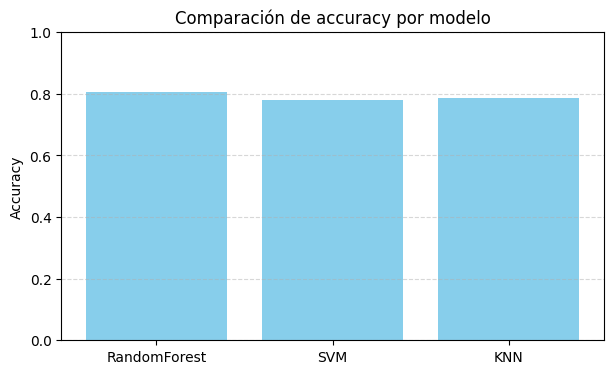

In [279]:


plt.figure(figsize=(7,4))
plt.bar(resultados.keys(), [r["accuracy"] for r in resultados.values()], color='skyblue')
plt.title("Comparación de accuracy por modelo")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


In [280]:
# Seleccionamos del mejor modelo
mejor_nombre = max(resultados, key=lambda k: resultados[k]['accuracy'])
mejor_modelo = resultados[mejor_nombre]["modelo"]
mejor_pred = resultados[mejor_nombre]["y_pred"]


In [281]:

print(f" Mejor modelo: {mejor_nombre} con accuracy = {resultados[mejor_nombre]['accuracy']:.4f}")
nombres_presentes = ['Gryffindor', 'Hufflepuff', 'Ravenclaw', 'Slytherin']
print(classification_report(y_test_f, mejor_pred, target_names=nombres_presentes))



 Mejor modelo: RandomForest con accuracy = 0.8050
              precision    recall  f1-score   support

  Gryffindor       0.58      0.47      0.52        45
  Hufflepuff       1.00      1.00      1.00        50
   Ravenclaw       1.00      1.00      1.00        52
   Slytherin       0.61      0.72      0.66        53

    accuracy                           0.81       200
   macro avg       0.80      0.80      0.79       200
weighted avg       0.80      0.81      0.80       200



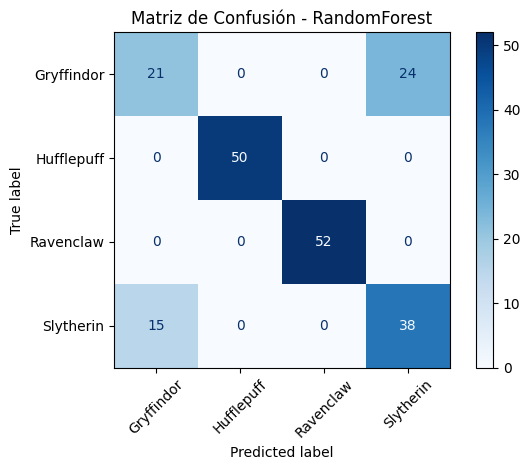

In [282]:
ConfusionMatrixDisplay.from_predictions(
    y_test_f,
    mejor_pred,
    display_labels=['Gryffindor', 'Hufflepuff', 'Ravenclaw', 'Slytherin'],
    cmap="Blues",
    xticks_rotation=45
)
plt.title(f"Matriz de Confusión - {mejor_nombre}")
plt.tight_layout()
plt.show()

## Interpretación de los resultados

**Accuracy general (80.5%)**:  
El modelo predice correctamente el 80.5% de los estudiantes en su casa de Hogwarts, lo cual es razonable pero no excelente. Hay margen para mejorar.

### Por clase:

Gryffindor (precisión 0.58, recall 0.47, f1 0.52):
- El modelo tiene dificultades para identificar correctamente a los estudiantes de Gryffindor.  
- Recall bajo (47%): muchos Gryffindor reales no son detectados (falsos negativos).  
- Precisión también baja (58%): de las predicciones Gryffindor, solo 58% son correctas.

Hufflepuff (precisión, recall y f1 = 1.00):
- Excelente desempeño para esta clase.  
- El modelo clasifica perfectamente a los estudiantes Hufflepuff sin errores.

Ravenclaw (precisión, recall y f1 = 1.00):
- También se predice perfectamente.

Slytherin (precisión 0.61, recall 0.72, f1 0.66):
- Rendimiento moderado.  
- El modelo detecta bien a Slytherin (recall 72%), pero la precisión es baja (61%) indicando que algunas predicciones Slytherin son incorrectas.


## Conclusiones

- **Desbalance o características poco claras para Gryffindor y Slytherin:**  
  La menor performance para estas casas sugiere que las características numéricas usadas pueden no diferenciar bien entre ellos, o hay solapamiento en sus atributos.

- **Hufflepuff y Ravenclaw se distinguen claramente:**  
  El modelo identifica muy bien estas dos casas, lo que puede deberse a características distintivas claras y poco solapamiento.

- **Necesidad de mejorar el modelo para casas más “difíciles”:**  
  Se pueden explorar técnicas para mejorar el rendimiento en Gryffindor y Slytherin:  
  - Obtener más datos o nuevas variables relevantes.   
  - Usar modelos más complejos o tuning más exhaustivo.  

- **El accuracy total es aceptable, pero el análisis por clase muestra disparidades:**  
  No basta con el accuracy general; el análisis clase por clase es fundamental para entender fortalezas y debilidades del modelo.